In [1]:
import numpy as np
from math import log, exp, inf, sqrt
from scipy import optimize
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
class Graph:
    def __init__(self, N, K, F_initialization_method='rand', E=None, logging=False):
        self.N = N
        self.V = list(range(1, N+1))
        
        self.E = []
        self.E_non = []
        if E is not None:
            self.add_edges_from(E)
        
        self.K = K
        self.C = list(range(1, K+1))
        
        self.colors = ['r', 'b', 'g', 'c']
        
        self.F = self.initialize_F(method=F_initialization_method, logging=logging)
    
    def initialize_F(self, method='rand', logging=False):
        if method == 'rand':
            F = np.random.random((self.N, self.K))
            if logging:
                print(F)
        elif method == 'cond':
            F = np.zeros((self.N, self.K))
            S = g.ego_graphs()
            for i in range(self.N):
                for j in range(self.K):
                    F[i, j] = 1 if self.V[i] in S[j] else F[i, j]
            if logging:
                print(F)
        elif method == 'cond_randz':
            F = np.random.random((self.N, self.K)) * 0.1
            S = g.ego_graphs()[0]
            for i in range(self.N):
                for j in range(self.K):
                    F[i, j] = 1 if self.V[i] in S[j] else F[i, j]
            if logging:
                print(F)
        elif method == 'cond_new':
            F = self.cond_new_initialization(np.zeros((self.N, self.K)))
            if logging:
                print(F)
        elif method == 'cond_new_randz':
            F = self.cond_new_initialization(np.random.random((self.N, self.K)) * 0.1)
            if logging:
                print(F)
        elif method == 'cond_randz_spr':
            F = np.random.random((self.N, self.K)) * 0.1
            S = g.ego_graphs()
            for i in range(self.N):
                for j in range(self.K):
                    F[i, j] = 1 if self.V[i] in S[j] else (0.5 if any(self.V[i] in self.neighbours(u) for u in S[j]) else F[i, j])
            if logging:
                print(F)
        elif method == 'cond_new_randz_spr':
            F = self.cond_new_spr_initialization(np.zeros((self.N, self.K)))
            if logging:
                print(F)
        else:
            F = np.random.random((self.N, self.K))
        return F
    
    def ego_graphs(self):
        ego_graphs_ = []
        for v in self.V:
            local_min = True
            for u in self.neighbours(v):
                if not (self.phi(self.neighbours(u)) > self.phi(self.neighbours(v))):
                    local_min = False
            if local_min:
                ego_graphs_.append(self.neighbours(v))
        return ego_graphs_
        
    def phi(self, S):
        T = list(set(self.V) - set(S))  
        return self.cut(S, T) / min(self.vol(S), self.vol(T))
    
    def cond_new_spr_initialization(self, F):
        i = 0
        for v in self.V:
            local_min = True
            for u in self.neighbours(v):
                if not (self.phi_new(self.neighbours(u), F) > self.phi_new(self.neighbours(v), F)):
                    local_min = False
            if local_min:
                for u in self.neighbours(v):
                    try:
                        F[u-1][i] = 1
                        for h in self.neighbours(u):
                            F[h-1][i] = 0.5 if F[h-1][i] != 1 else 1
                    except:
                        return F
                i += 1
        return F 
    
    def cond_new_initialization(self, F):
        i = 0
        for v in self.V:
            local_min = True
            for u in self.neighbours(v):
                if not (self.phi_new(self.neighbours(u), F) > self.phi_new(self.neighbours(v), F)):
                    local_min = False
            if local_min:
                for u in self.neighbours(v):
                    try:
                        F[u-1][i] = 1
                    except:
                        return F
                i += 1
        return F 
    
    def phi_new(self, S, F):
        T = list(set(self.V) - set(S))  
        phi = self.cut(S, T) / min(self.vol(S), self.vol(T))
        
        Fs = []
        Fei = []
        for l in self.V:
            Fs.append(1 if any(np.array(F[l-1]) == 1) else 0)
        for l in self.V:
            Fei.append(1 if l in S else 0)
        try:
            y = 1 / sum(Fs)
            R = y * np.dot(np.array(Fs).T, np.array(Fei))
        except:
            R = 0
        phi_new_ = phi + R
        return phi_new_     
    
    def neighbours(self, v):
        n = []
        for e in self.E:
            if v in e:
                n.append(e[0] if e[1] == v else e[1])
        return n
    
    def cut(self, S, T):
        cut_ = 0
        for e in self.E:
            v, u = e[0], e[1]
            if (v in S and u in T) or (v in T and u in S):
                cut_ += 1
        return cut_
    
    def vol(self, S):
        vol_ = 0
        for e in self.E:
            v, u = e[0], e[1]
            if (v in S) or (u in S):
                vol_ += 1
        return vol_
    
    def add_edges_from(self, E):
        self.E = E
        
        for u in self.V:
            for v in self.V[u:]:
                if (u, v) not in E:
                    self.E_non.append([u, v, 0])
    
    def l(self, x):
        x = x.reshape(len(self.V), len(self.C))
        l = 0
        for e in self.E:
            u, v = e[0], e[1]
            try:
                l += log(1 - exp(-np.dot(x[u-1], x[v-1].T)))
            except ValueError:
                l += -1e3
        for e in self.E_non:
            u, v = e[0], e[1]
            l -= np.dot(x[u-1], x[v-1].T)
        return l * (-1)
    
    def detect_communities(self, method='BigCLAM', logging=False):
        result = optimize.minimize(self.l,self.F, method='L-BFGS-B', bounds=[(0, 1)]*(self.N*self.K))
        if logging:
            print(result)
        self.F = result['x'].reshape(len(self.V), len(self.C))
        return self.F
    
    def detect_overlapping_communities(self, method='BigCLAM', logging=False):
        result = optimize.minimize(self.l,self.F, method='L-BFGS-B', bounds=[(0, 1)]*(self.N*self.K))
        if logging:
            print(result)
        self.F = result['x'].reshape(len(self.V), len(self.C))
        e = (2 * self.N) / (len(self.E)*(len(self.E) - 1))
        self.d = sqrt(-log(1-e))
        return self.F, self.F > self.d
    
    def visualize(self, logging=False):
        G = nx.Graph()

        for v in self.V:
            G.add_node(v)
        for e in self.E:
            G.add_edge(e[0], e[1], weight=e[2])

        pos = nx.spring_layout(G)

        for j, c in enumerate(self.C):
            vv = []
            for i, v in enumerate(self.F):
                try:
                    if (self.F > self.d)[i, j]:
                        vv.append(i+1)
                except AttributeError:
                    if np.argmax(v) + 1 == c:
                        vv.append(i+1)
            if logging:
                print("Community №" + str(j+1) + ":", "; ".join(list(map(str, vv))))
                
            nx.draw_networkx_nodes(G, pos, nodelist=vv, node_size=700, node_color=self.colors[j])

        nx.draw_networkx_edges(G, pos, width=2)
        nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')

        plt.axis('off')
        plt.show()

Community №1: 1; 2; 3; 4; 5; 6
Community №2: 7; 8; 9; 10
Community №3: 16; 17; 18; 19; 20
Community №4: 11; 12; 13; 14; 15


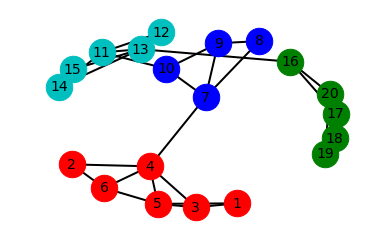

In [3]:
g = Graph(N=20, K=4, F_initialization_method='cond_new_randz_spr', 
          E=[[1, 3, 1], [4, 3, 1], [5, 4, 1], [3, 5, 1], [2, 4, 1], [2, 6, 1], [2, 4, 1], [1, 5, 1], [6, 5, 1], [6, 4, 1],
             [7, 4, 1], [7, 9, 1], [8, 9, 1], [7, 8, 1], [7, 10, 1], [10, 9, 1], [10, 11, 1],
             [11, 12, 1], [13, 12, 1], [11, 13, 1], [15, 13, 1], [15, 14, 1], [11, 14, 1], [13, 14, 1],
             [13, 16, 1], [16, 17, 1], [17, 18, 1], [18, 19, 1], [19, 20, 1], [20, 16, 1], [17, 19, 1]], 
          logging=False)

g.detect_communities(method='BigCLAM', logging=False)
g.visualize(logging=True)